This notebook, by [felipe.alonso@urjc.es](mailto:felipe.alonso@urjc.es)

In this notebook we will:

1. Learn how to test for normality in the data

2. Solve hypothesis testing examples using `scipy.stats` nonparametric methods:

    - Sign test: with the [`binom_test`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html)
    - Wilcoxon signed-rank test: [`wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon)
    - Rank-sum test. There are two options here, depending on how **tied observations** are handle.
        * [`ranksums`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html#scipy.stats.ranksums)
        * [`mannwhitneyu`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html#scipy.stats.mannwhitneyu)
      
### Preliminaries:

- #### Tied observations

Tied observations are **observations having the same value**, which prohibits the assignment of unique rank numbers. As a way out tied observations are assigned to the average of their hypothetical ranks.

The difference between `ranksums` and `mannwhitneyu` is that `ranksums` does not handle **ties** between measurements in `x` and `y`.


- #### Nonparametric assumptions

A common mistake is to think such tests require no assumptions, but this is not true. The assumption made for the Wilcoxon test is that the variable being tested is **symmetrically distributed about the median**, which would also be the mean.

---
# 0. Load libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

from scipy.stats import norm, uniform, expon, t
from scipy.stats import kstest, shapiro
from scipy.stats import wilcoxon, ttest_1samp, ttest_rel, mannwhitneyu

---
# 1. Test for normality

There are several methods of assessing whether data are normally distributed or not. A nice review of methods can be found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/). There are two main approaches:

1. Visual methods
    - Histogram, boxplots, [QQ-plots](https://www.statisticshowto.datasciencecentral.com/q-q-plots/)
2. Statistical methods
    - Kolgomorov-Smirnov test, Shapiro-Wilk test, among others.
    
    
### When is non-normality a problem?

1. Small sample size (< 50)
2. Highly skewed data
3. Outliers
4. When there is “activity” in the tails of the data set.

## 1.1 Visual methods

Visual inspection of the distribution may be used for assessing normality, although this approach is usually unreliable and does not guarantee that the distribution is normal.

In [2]:
def visual_normality_test(x, bins = 20):
        
    mu = np.mean(x)
    sigma = np.std(x, ddof = 1) # unbiased std

    plt.figure(figsize = (20,4))

    ax1 = plt.subplot(1,3,1)
    ax1.hist(x,bins=bins, density = True)
    x_axis = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    ax1.plot(x_axis,norm.pdf(x_axis, mu, sigma),'r',linewidth=2)
    ax1.set_title('Normalized histogram')
    
    ax2 = plt.subplot(1,3,2)
    ax2.boxplot(x)
    ax2.set_title('Boxplot')
    
    ax3 = plt.subplot(1,3,3)
    sm.qqplot(x, line='s', ax=ax3)
    ax3.set_title('QQ Plot')

    plt.show()

### Example 1:

<div class="alert alert-block alert-info">
Test how the above function works on normal, uniform and exponential random variables.
</div>

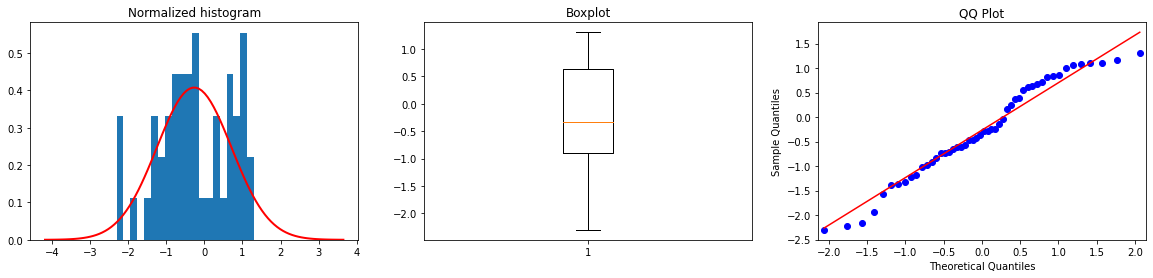

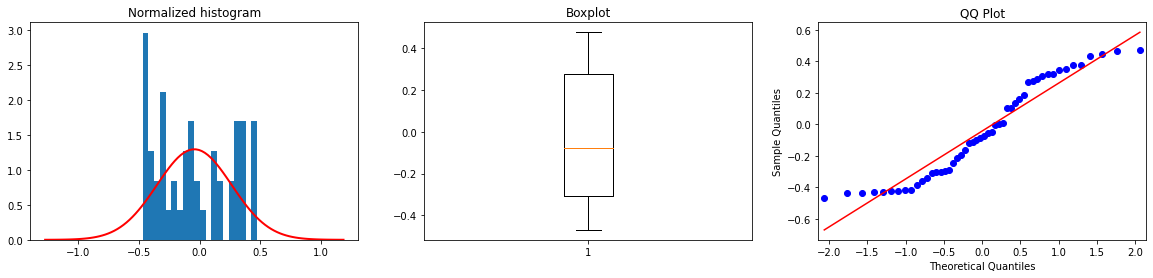

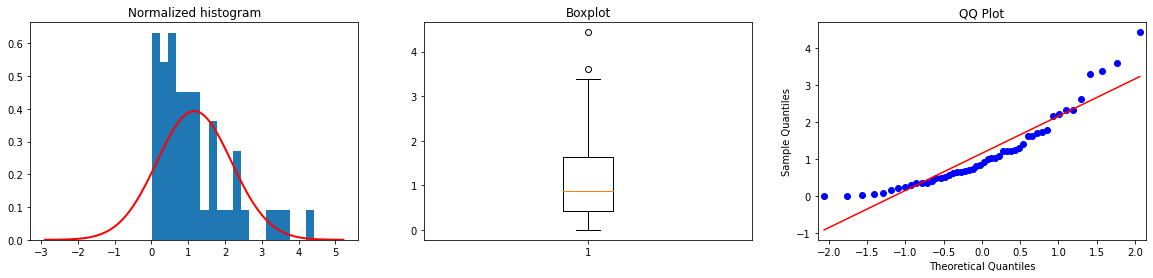

In [4]:
n = 50

normal_sample  = norm.rvs(size = n)
uniform_sample = uniform.rvs(size = n) - 0.5
expon_sample   = expon.rvs(size = n)

visual_normality_test(normal_sample)
visual_normality_test(uniform_sample)
visual_normality_test(expon_sample)

## 1.2 Statistical methods

The normality tests compare the scores in the sample to a normally distributed set of scores with the same mean and standard deviation. 

The hypotheses used are:
- $H_0$: The sample data are not significantly different than a normal population.
- $H_1$: The sample data are significantly different than a normal population.


### 1.2.1 Kolmogorov-Smirnov (KS) test

This performs a test of the distribution $F(x)$ of an observed random variable against a given distribution $G(x)$. Under the null hypothesis, the two distributions are identical, $F(x)=G(x)$.

- The KS test is well-known but it has not much power. This means that a large number of observations ($n>50$) is necessary to reject the null hypothesis. 
- It is also sensitive to outliers

In Python, it is implemented by `scipy.stats` under the [`kstest`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest) function.

### Example 2:

<div class="alert alert-block alert-info">
Run the following code for random variables drawn from different distributions and different sample sizes
</div>

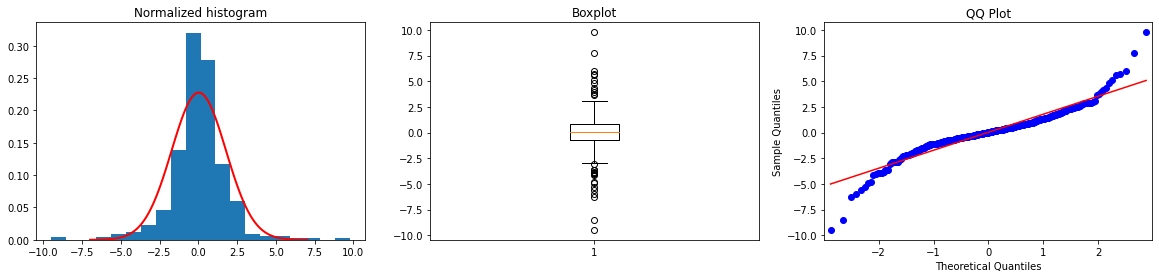

Statistic: 0.10442496393958747 	 p-value: 3.353335864957106e-05


In [10]:
n = 500

normal_sample  = norm.rvs(size = n)
uniform_sample = uniform.rvs(size = n) - 0.5
expon_sample   = expon.rvs(size = n)
t_sample       = t(df=3).rvs(size=n)

x = t_sample
visual_normality_test(x)
ks_statistic, p_value = kstest(x, 'norm', args = (x.mean(),x.std()))
print('Statistic:', ks_statistic, '\t p-value:', p_value)

### 1.2.2 Shapiro-Wilk (SW) test

The [SW test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) is based on the correlation between the data and the corresponding normal scoresand provides **better power than the KS test**. 

The Shapiro Wilk test is the most powerful test when testing for a normal distribution. It has been developed specifically for the normal distribution and it cannot be used for testing against other distributions like for example the KS test.

- Works best for data sets with $n < 50$, but can be used with larger data sets.

In Python, it is implemented by `scipy.stats` under the [`shapiro`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html#scipy.stats.shapiro) function. Notice that for $N > 5000$ the $W$ test statistic is accurate but the p-value may not be.

### Example 3:

<div class="alert alert-block alert-info">
Run the following code for random variables drawn from different distributions and different sample sizes. Compare the results with the KS test
</div>

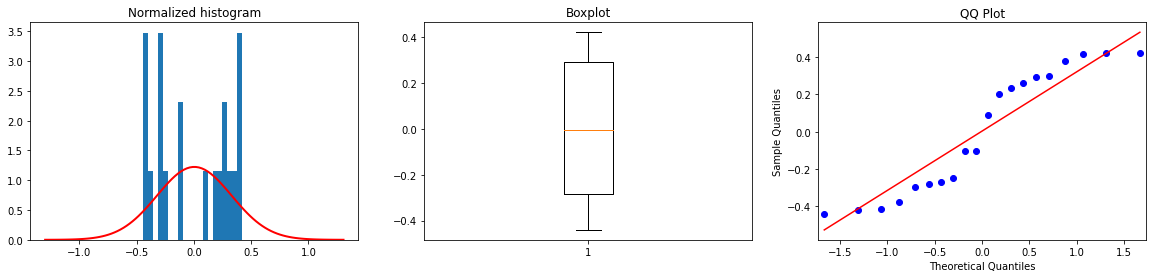

KS Statistic: 0.1836823412748269 	 p-value: 0.4559194620321849
SW Statistic: 0.8734953999519348 	 p-value: 0.01354183629155159


In [11]:
n = 20

normal_sample  = norm.rvs(size = n)
uniform_sample = uniform.rvs(size = n) - 0.5
expon_sample   = expon.rvs(size = n)
t_sample       = t(df=3).rvs(size=n)

x = uniform_sample

visual_normality_test(x)

ks_statistic, p_value = kstest(x, 'norm', args = (x.mean(),x.std()))
print('KS Statistic:', ks_statistic, '\t p-value:', p_value)

sw_statistic, p_value = shapiro(x)
print('SW Statistic:', sw_statistic, '\t p-value:', p_value)

### 1.3 Summary

- Use visual method, together with statistical test
- For $n>50$ use the KS test
- For $n<50$ use the SW test

Notice that, as it is mentioned [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/), for small sample sizes, normality tests have little power to reject the null hypothesis and therefore small samples most often pass normality tests

---

# 2. Nonparametric methods

A nice review can be found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC153434/).

Due to its flexibility, nonparametric methods are commonly used in research:

- [Nättinen, J., Jylhä, A., Aapola, U. et al. Patient stratification in clinical glaucoma trials using the individual tear proteome. Sci Rep 8, 12038 (2018).](https://www.nature.com/articles/s41598-018-30369-x#citeas)

- [Rapid and active stabilization of visual cortical firing rates across light–dark transitions
Alejandro Torrado Pacheco, et al. Proceedings of the National Academy of Sciences Sep 2019, 116 (36) 18068-18077](https://www.pnas.org/content/pnas/116/36/18068.full.pdf)

### Exercise 1:

We want to test if a clinical intervention had a significant effect on the blood pressure. The file `./data/blood_preassure.csv` contains blood pressure readings before (`bp_before`) and after (`bp_after`) an intervention. 

<div class="alert alert-block alert-info">
Use an appropiate test to address this question
</div>

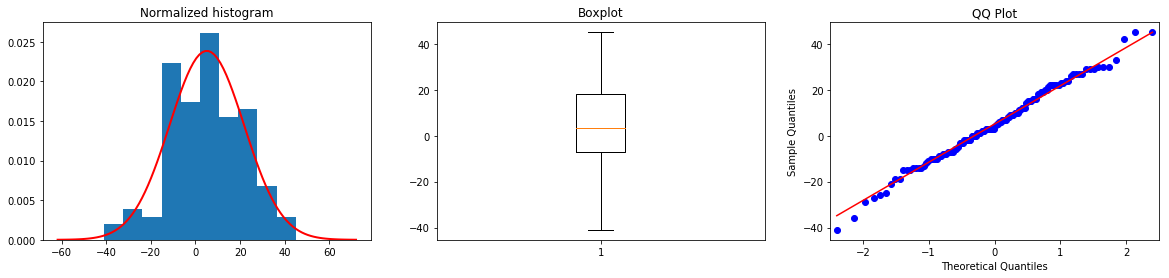

Looks like a normal distribution, p-value: 0.9250387239622251


In [6]:
bp_data = pd.read_csv('../data/blood_pressure.csv')
x = (bp_data['bp_before'] - bp_data['bp_after']).values

# 1. Check if data is normaly distributed
visual_normality_test(x, bins=10)
if x.shape[0] > 50:
    _, p_value = kstest(x,'norm', args=(x.mean(), x.std()) )
else:
    _, p_value = shapiro(x)
    
if p_value > 0.05: 
    print('Looks like a normal distribution, p-value:', p_value)
else:
    print('Does not lool like a normal distribution, p-value:', p_value)

In [7]:
# your code here
# ...

# SOLUTION: Given that our sample can be fitted to a normal distribution, we could use a t-test. 
# Notice also that this is paired experiment. 

from scipy.stats import ttest_1samp, ttest_rel, wilcoxon

# Option 1: paired t-test analysis H0: mu_before-mu_after = 0 vs H1: mu_before-mu_after != 0
statistic, p_value_1 = ttest_rel(bp_data['bp_before'],bp_data['bp_after'])
print('Paired t-test p-value:\t\t', p_value_1)

# Option 2: paired t-test analysis H0: mu_before-mu_after = 0 vs H1: mu_before-mu_after != 0
# The previous test can be replicated using a one sample t-test
statistic, p_value_2 = ttest_1samp(x, 0)
print('One sample t-test p-value:\t', p_value_2)

# Option 3: we might want to use a nonparametric test, if we do not trust our data follows a normal distribution
# it should be like a worst case scenario

statistic, p_value_3 = wilcoxon(x)
print('Wilcoxon test p-value:\t\t', p_value_3)


if p_value_1 < 0.05:
    print('\n- We reject the null hypothesis H0, the intervention had a significant effect on the blood pressure')
else:
    print('\n- We fail to reject the null hypothesis H0: the intervention did not have a significant effect on the blood pressure ')
    

Paired t-test p-value:		 0.0011297914644840823
One sample t-test p-value:	 0.0011297914644840823
Wilcoxon test p-value:		 0.0014107333565442858

- We reject the null hypothesis H0, the intervention had a significant effect on the blood pressure


### Exercise 2:

You might wish to investigate whether the women’s energy intake deviates systematically from a recommended value of $1854\,\textrm{kcal}$. You have a sample of observations for eleven women

$$\text{sample }=[1262.4, 1312.8, 1353.6, 1483.2, 1533.6, 1563.6, 1633.2, 1803.6, 1803.6, 1975.2, 2104.8]\,\textrm{kcal}$$

<div class="alert alert-block alert-info">
Use an appropiate test to address this question
</div>

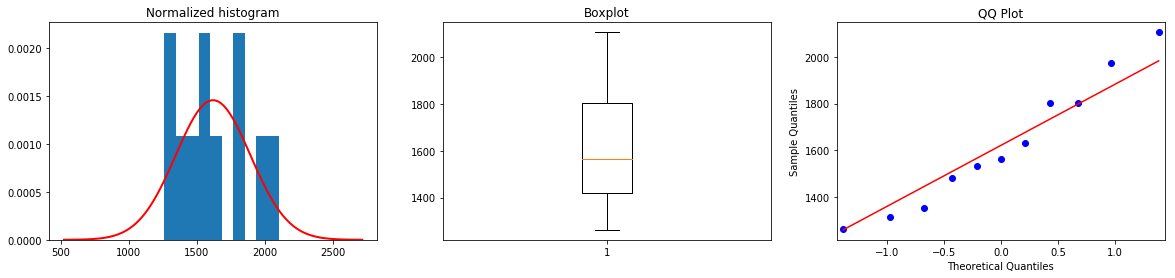

Looks like a normal distribution, p-value: 0.6743023991584778

Wilcoxon test p-value:		 0.026157182329284684
One sample t-test p-value:	 0.018137235176105812

- We reject the null hypothesis H0, women’s energy intake deviates systematically from a recommended value of 1854kcal


In [8]:
daily_intake = np.array([1262.4, 1312.8, 1353.6, 1483.2, 1533.6, 1563.6, 1633.2, 1803.6, 1803.6, 1975.2, 2104.8])

x = daily_intake

# 1. Check if data is normaly distributed
visual_normality_test(x, bins=10)
if len(x) > 50:
    _, p_value = kstest(x,'norm', args=(x.mean(), x.std()) )
else:
    _, p_value = shapiro(x)
    
if p_value > 0.05: 
    print('Looks like a normal distribution, p-value:', p_value)
else:
    print('Does not lool like a normal distribution, p-value:', p_value)

    
# SOLUTION: even if the Shapiro test tells us that our data follows a normal distribution, the sample size is 
# too small so if is a good practice to use in this case a nonparametric test

# Option 1. WILCOXON. H0: median = 1854 vs H1: median != 1854
z_statistic, p_value_1 = wilcoxon(daily_intake - 1854)
print('\nWilcoxon test p-value:\t\t', p_value_1)

# Option 2. One sample t-test. H0: mu = 1854 vs H1: mu != 1854
t_statistic, p_value_2 = ttest_1samp(daily_intake, 1854)
print('One sample t-test p-value:\t', p_value_2)


if p_value_1 < 0.05:
    print('\n- We reject the null hypothesis H0, women’s energy intake deviates systematically from a recommended value of 1854kcal')
else:
    print('\n- We fail to reject the null hypothesis H0, women’s energy intake does not deviat systematically from a recommended value of 1854kcal ')

### Exercise 3:

An environmental activist believes her community’s drinking water contains at least the 40.0 parts per million (ppm) limit recommended by health officials for a certain metal. In response to her claim, the health department samples and analyzes drinking water from a sample of 11 households in the community. The results are as in the table below

|Household|Observed concentration|
|---|---|
|A|39| 
|B|20.2|
|C|40|
|D|32.2|
|E|30.5|
|F|26.5|
|G|42.1|
|H|45.6|
|I|42.1|
|J|29.9|
|K|40.9|

<div class="alert alert-block alert-info">
At the 0.05 level of significance, can we conclude that the community’s drinking water might at least 40.0 ppm recommended limit?
</div>

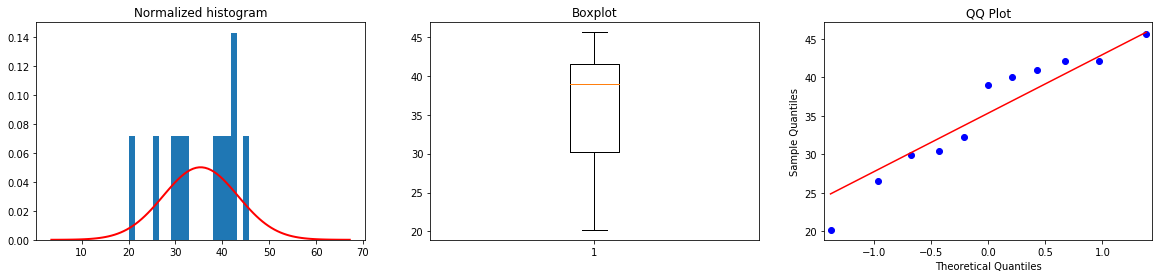

Looks like a normal distribution, p-value: 0.35657998919487

Wilcoxon test p-value:		 0.998334993044127

- We fail to reject the null hypothesis H0, city’s water supply might have at least 40.0 ppm of the metal


In [9]:
# Your code here
# ...

obs_concentration = np.array([39,20.2,40,32.2,30.5,26.5,42.1,45.6,42.1,29.9,40.9])

# SOLUTION: in this case, we have a one-sided hypothesis test. We will use a nonparametric method, 
# due to the small sample size
# H0: median >= 40 vs H1: median < 40
# Or in other words:
# - H0: community’s drinking water might at least 40.0ppm recommended limit >= 40
# - H1: community’s drinking water might at least 40.0ppm recommended limit < 40

# 1. Check if data is normaly distributed
visual_normality_test(obs_concentration)
if len(obs_concentration) > 50:
    _, p_value = kstest(obs_concentration,'norm', args=(obs_concentration.mean(), obs_concentration.std()) )
else:
    _, p_value = shapiro(obs_concentration)
    
if p_value > 0.05: 
    print('Looks like a normal distribution, p-value:', p_value)
else:
    print('Does not lool like a normal distribution, p-value:', p_value)

# 2. Hypothesis test
z_statistic, p_value = wilcoxon(obs_concentration, alternative='less')
print('\nWilcoxon test p-value:\t\t', p_value)

if p_value < 0.05:
    print('\n- We reject the null hypothesis H0, city’s water supply does not have at least 40.0 ppm of the metal')
else:
    print('\n- We fail to reject the null hypothesis H0, city’s water supply might have at least 40.0 ppm of the metal')

### Exercise 4:

Student satisfaction surveys ask students to rate a particular course, on a scale of 1 (poor) to 10 (excellent). In previous years the replies have been symmetrically distributed about a median of 4. This year there has been a much greater on-line element to the course, and staff want to know how the rating of this version of the course compares with the previous one. 14 students, randomly selected, were asked to rate the new version of the course and their ratings were as follows:

$$\text{sample }= [1,3,6,4,8,2,3,6,5,2,3,4,1,2]$$

<div class="alert alert-block alert-info">
Is there any evidence at the 5% level that students rate this version any differently?
</div>

In [10]:
# Your code here
# ...

# SOLUTION: In this case we have ordinal data, so it is mandatory to use a nonparametric test
# H0: median = 4 vs H1: median != 4 

sample = np.array([1,3,6,4,8,2,3,6,5,2,3,4,1,2])

z_statistic, p_value = wilcoxon(sample-4)
print('\nWilcoxon test p-value:\t\t', p_value)

if p_value < 0.05:
    print('\n- We reject the null hypothesis H0, this course is different to the previous one')
else:
    print('\n- We fail to reject the null hypothesis H0, this course is similar to the previous one')


Wilcoxon test p-value:		 0.40445689647910377

- We fail to reject the null hypothesis H0, this course is similar to the previous one


### Exercise 5: 

we consider a study investigating potential links between diet and physical development. Height and weight data have been gathered from two cohorts: one of subjects who had suffered from malnutrition in childhood (cohort A) and one of subjects who had not (cohort B). The height and weight data are shown in the following table.


|A: Height (cm)| A: Weight (kg)| B: Height (cm)|B: Weight (kg)|
|:-:|:-:|:-:|:-:|
|180|78|165|83|
|170|76|187|82|
|163|80|161|100|
|171|78|165|83|
|167|76|163|74|
|155|73|158|101|
|174|74| - | - |

<div class="alert alert-block alert-info">
Are heights of the subjects in cohorts A and B  different?
</div>

In [11]:
# Your code here
# ...

height_A = np.array([180,170,163,171,167,155,174])
height_B = np.array([165,187,161,165,163,158])

x = height_B
if len(x) > 50:
    _, p_value = kstest(x,'norm', args=(x.mean(), x.std()) )
else:
    _, p_value = shapiro(x)
    
if p_value > 0.05: 
    print('Looks like a normal distribution, p-value:', p_value)
else:
    print('Does not lool like a normal distribution, p-value:', p_value)


# We will use the MannWhitneyU test

from scipy.stats import mannwhitneyu

z_statistic, p_value = mannwhitneyu(height_A,height_B)
print('\nWilcoxon test p-value:\t\t', p_value)

if p_value < 0.05:
    print('\n- We reject the null hypothesis H0, cohorts are different')
else:
    print('\n- We fail to reject the null hypothesis H0, we cannot state that cohorts are not different')


Does not lool like a normal distribution, p-value: 0.014952290803194046

Wilcoxon test p-value:		 0.19503032130692605

- We fail to reject the null hypothesis H0, we cannot state that cohorts are not different


### Exercise 6:

Data below show the marks obtained by Biomedical Engineering students in a midterm examination

|Gender|Mark|
|---|---|
|Male|6,94|
|Female|6,67|
|Male|7,78|
|Female|3,89|
|Male|7,78|
|Female|1,39|
|Female|8,89|
|Female|1,11|
|Female|7,78|
|Male|5,83|
|Female|8,89|
|Female|5,56|
|Female|8,89|
|Female|5,00|
|Male|10,00|
|Female|8,89|
|Male|5,00|
|Male|2,22|
|Female|1,39|
|Male|5,83|
|Male|8,89|

<div class="alert alert-block alert-info">
Can we conclude that the achievements of male and female students are identical?
</div>

In [12]:
# Your code here
# ...

male_marks   = np.array([6.94,7.78,7.78,5.83,10.0,5.00,2.22,5.83,8.89])
female_marks = np.array([6.67,3.89,1.39,8.89,1.11,7.78,8.89,5.56,8.89,5.00, 8.89,1.39])

x = female_marks
if len(x) > 50:
    _, p_value = kstest(x,'norm', args=(x.mean(), x.std()) )
else:
    _, p_value = shapiro(x)
    
if p_value > 0.05: 
    print('Looks like a normal distribution, p-value:', p_value)
else:
    print('Does not lool like a normal distribution, p-value:', p_value)
    
# We will use the mannwhitneyu test
z_statistic, p_value = mannwhitneyu(male_marks,female_marks)
print('\nWilcoxon test p-value:\t\t', p_value)

if p_value < 0.05:
    print('\n- We reject the null hypothesis H0, achivements are not identical')
else:
    print('\n- We fail to reject the null hypothesis H0, we cannot conclude that achivements are not identical')

Does not lool like a normal distribution, p-value: 0.04003322497010231

Wilcoxon test p-value:		 0.25937162112521617

- We fail to reject the null hypothesis H0, we cannot conclude that achivements are not identical
